from sklearn.model_selection import train_test_split
import pandas as pd
import os
# ^^^ pyforest auto-imports - don't write above this line
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

# Clinical Deterioration Prediction Model - Bayesian Linear Regression

## Data

The final dataset used for the inferential statistics project includes unique ICU admission of 46,234 patients’ demographic (age), vital (blood pressure, heart rate, body temperature, and Glasgow Comma Scale), underlying conditions (HIV, metastatic cancer, and hematologic malignancy), admission type (scheduled surgical, medical, or unscheduled surgical), renal (urinary output, and Blood Urea Nitrogen), and others (serum bicarbonate level, sodium level, potassium level, and bilirubin level) data. This dataset is build based on the commonly used mortality prediction tool, Simplified Acute Physiology Score II (SAPSII). 

In [1]:
os.getcwd()

<IPython.core.display.Javascript object>

'C:\\Users\\abebu\\Dropbox\\Data Science\\Projects\\Mini_Projects\\Project11\\logistic_regression\\Logistic-Regression-and-Hyperparameter-Tuning'

In [2]:
os.chdir("C://Users/abebu/Google Drive/mimic-iii-clinical-database-1.4")

<IPython.core.display.Javascript object>

In [3]:
saps = pd.read_csv("sapsDummies.csv", header=0, index_col=0)
saps.head()

<IPython.core.display.Javascript object>

,Unnamed: 0,SUBJECT_ID,HADM_ID,ICUSTAY_ID,los,hdeath,death,saps2,admission_0,admission_8,...,bp_2.0,bp_5.0,bp_13.0,AGE_0.0,AGE_7.0,AGE_12.0,AGE_15.0,AGE_16.0,AGE_18.0,UO_0.0
0,0,268,110404,280836,3.2490,1,1,82.0,0,1,...,0,0,1,0,0,1,0,0,0,1
1,1,269,106296,206613,3.2788,0,0,37.0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,2,270,188028,220345,2.8939,0,0,45.0,1,0,...,0,0,1,0,0,0,0,0,1,1
3,3,271,173727,249196,2.0600,0,0,24.0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,4,272,164716,210407,1.6202,0,0,28.0,0,1,...,0,1,0,0,0,1,0,0,0,1


In [4]:
list(saps.columns)

['Unnamed: 0',
 'SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'los',
 'hdeath',
 'death',
 'saps2',
 'admission_0',
 'admission_8',
 'ud_0.0',
 'ud_9.0',
 'ud_10.0',
 'ud_17.0',
 'bun_0.0',
 'bun_6.0',
 'bun_10.0',
 'Bicarbonate_0.0',
 'Bicarbonate_3.0',
 'Bicarbonate_6.0',
 'ventilation_0.0',
 'ventilation_6.0',
 'ventilation_9.0',
 'ventilation_11.0',
 'Potassium_0.0',
 'Potassium_3.0',
 'Sodium_0.0',
 'Sodium_1.0',
 'Sodium_5.0',
 'Temp_0.0',
 'Temp_3.0',
 'Bilirubin_0.0',
 'Bilirubin_4.0',
 'Bilirubin_9.0',
 'WBC_0.0',
 'WBC_3.0',
 'hr_0.0',
 'hr_2.0',
 'hr_4.0',
 'hr_7.0',
 'hr_11.0',
 'gcs_0.0',
 'gcs_5.0',
 'gcs_7.0',
 'gcs_26.0',
 'bp_0.0',
 'bp_2.0',
 'bp_5.0',
 'bp_13.0',
 'AGE_0.0',
 'AGE_7.0',
 'AGE_12.0',
 'AGE_15.0',
 'AGE_16.0',
 'AGE_18.0',
 'UO_0.0']

In [5]:
saps=saps.drop(['Unnamed: 0', 'SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'los','death', 'saps2'], axis=1)

In [12]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [13]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [14]:

# PyMC3 for Bayesian Inference
import pymc3 as pm

In [6]:

# grade and returns training and testing datasets
def format_data(df):
    # Target is hospital death
    labels = saps['hdeath']
    
    # Drop target (hdeath) from features
    df = df.drop(columns=['hdeath'])
    
    # Split into training/testing sets with 30% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.30,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test


In [7]:
X_train, X_test, y_train, y_test = format_data(saps)
X_train.head()


<IPython.core.display.Javascript object>

,admission_0,admission_8,ud_0.0,ud_9.0,ud_10.0,ud_17.0,bun_0.0,bun_6.0,bun_10.0,Bicarbonate_0.0,...,bp_2.0,bp_5.0,bp_13.0,AGE_0.0,AGE_7.0,AGE_12.0,AGE_15.0,AGE_16.0,AGE_18.0,UO_0.0
53545,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
51512,0,1,1,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,1
23837,0,1,1,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
21929,1,0,1,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,1
57339,0,1,1,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1


In [8]:
print(X_train.shape)
print(X_test.shape)

(42781, 48)
(18336, 48)


### Standard Machine Learning Models

In [23]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    #Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    model = np.arange(1, 7)
    train_accuracy = np.empty(len(model))
    test_accuracy = np.empty(len(model))
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    results =pd.DataFrame(columns=['train_accuracy', 'test_accuracy'])    
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        
        train_accuracy=model.score(X_train, y_train)
        test_accuracy=model.score(X_test, y_test)
        
        model_name=model_name_list[i]
        results.loc[model_name, :] =[train_accuracy, test_accuracy]
    return results
    

In [24]:
results = evaluate(X_train, X_test, y_train, y_test)
results

,train_accuracy,test_accuracy
Linear Regression,0.306738,0.316917
ElasticNet Regression,0,-0.00012427
Random Forest,0.58213,0.31253
Extra Trees,0.609777,0.196629
SVM,0.290899,0.302108
Gradient Boosted,0.313493,0.323378


In [26]:
saps = pd.read_csv("saps_ts.csv", header=0, index_col=0)
saps.head()

,Unnamed: 0.1,SUBJECT_ID,HADM_ID,ICUSTAY_ID,los,hdeath,death,admission,ud,bun,...,Sodium,Temp,Bilirubin,WBC,hr,gcs,bp,AGE,UO,saps2
0,0,268,110404,280836,3.2490,1,1,8,0.0,6.0,...,0.0,0.0,0.0,0.0,11.0,26.0,13.0,12.0,0.0,82.0
1,1,269,106296,206613,3.2788,0,0,8,17.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,7.0,0.0,37.0
2,2,270,188028,220345,2.8939,0,0,0,0.0,0.0,...,0.0,3.0,0.0,0.0,11.0,0.0,13.0,18.0,0.0,45.0
3,3,271,173727,249196,2.0600,0,0,8,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0
4,4,272,164716,210407,1.6202,0,0,8,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,5.0,12.0,0.0,28.0


In [28]:
saps=saps.drop(['Unnamed: 0.1', 'SUBJECT_ID',
 'HADM_ID',
 'ICUSTAY_ID',
 'los','death', 'saps2'], axis=1)

In [29]:
# grade and returns training and testing datasets
def format_data(df):
    # Target is hospital death
    labels = saps['hdeath']
    
    # Drop target (hdeath) from features
    df = df.drop(columns=['hdeath'])
    
    # Split into training/testing sets with 30% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.30,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test


In [30]:
X_train, X_test, y_train, y_test = format_data(saps)
X_train.head()


,admission,ud,bun,Bicarbonate,ventilation,Potassium,Sodium,Temp,Bilirubin,WBC,hr,gcs,bp,AGE,UO
53545,8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
51512,8,0.0,6.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,5.0,18.0,0.0
23837,8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,5.0,12.0,0.0
21929,0,0.0,10.0,0.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,13.0,18.0,0.0
57339,8,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,5.0,12.0,0.0


In [31]:
print(X_train.shape)
print(X_test.shape)

(42781, 15)
(18336, 15)


In [32]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    #Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    model = np.arange(1, 7)
    train_accuracy = np.empty(len(model))
    test_accuracy = np.empty(len(model))
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    results =pd.DataFrame(columns=['train_accuracy', 'test_accuracy'])    
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        
        train_accuracy=model.score(X_train, y_train)
        test_accuracy=model.score(X_test, y_test)
        
        model_name=model_name_list[i]
        results.loc[model_name, :] =[train_accuracy, test_accuracy]
    return results
    

In [33]:
results = evaluate(X_train, X_test, y_train, y_test)
results

,train_accuracy,test_accuracy
Linear Regression,0.270304,0.282158
ElasticNet Regression,0.0463146,0.0476076
Random Forest,0.581339,0.309269
Extra Trees,0.609777,0.249717
SVM,0.465584,0.27595
Gradient Boosted,0.311739,0.322031


In [34]:
# Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'hdeath ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'hdeath ~ ud + bun + Bicarbonate + ventilation + Potassium + Sodium + Temp + Bilirubin + WBC + hr + gcs + bp + AGE + UO'


### Create Model in PyMC3 and Sample from Posterior
We now build the model using the formula defined above and a normal distribution for the data likelihood. Then, we let a Markov Chain Monte Carlo algorithm draw samples from the posterior to approximate the posterior for each of the model parameters.

In [38]:

# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = saps, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 4, tune = 500, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, UO, AGE, bp, gcs, hr, WBC, Bilirubin, Temp, Sodium, Potassium, ventilation, Bicarbonate, bun, ud, Intercept]
Sampling 4 chains: 100%|██████████| 10000/10000 [13:36<00:00, 12.24draws/s] 
The acceptance probability does not match the target. It is 0.9958113864086459, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9451145250594433, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9887886846515214, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9498654498476294, but should be close to 0.8. Try to increase the number of tuning steps.


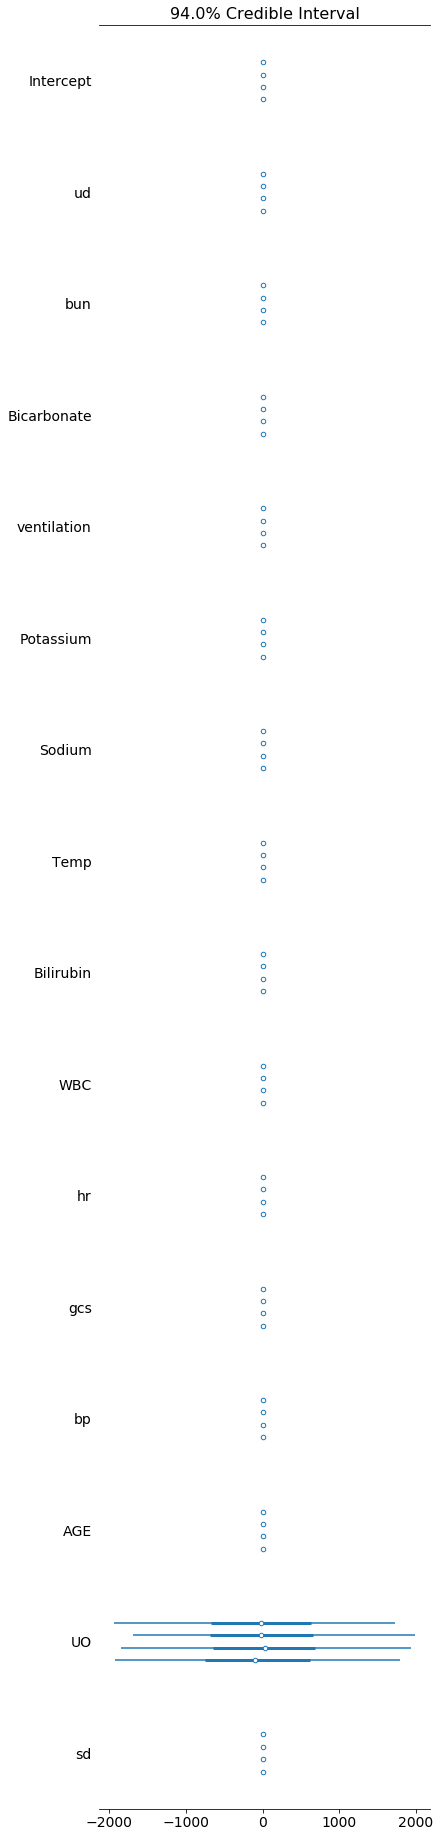

In [39]:
pm.forestplot(normal_trace);